This notebook evaluates the performance of just parallelizing the similarity over CPUs (**not GPUs**).

In [1]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'GNPS-LIBRARY-default-filter-nmax-2048.pickle'

# We take a random sample of spectra from said file

# Minimum size:
chunk_sizes_min = 32

# Maximum size
chunk_sizes_max = 1024

# how many points to evaluate (in logspace) between min and max
num_evals = 15

! echo Number of CPU cores $(nproc)

Number of CPU cores 12


In [2]:
from cudams.utils import argbatch, Timer
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from cudams.utils import Timer

spectra = pickle.load(open(download(spectra_file),'rb'))
spectra = spectra[:chunk_sizes_max]

/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype
100%|██████████████████████████████████████| 86.7M/86.7M [00:00<00:00, 161GB/s]
SHA256 hash of downloaded file: 9797fa1068f59c6e2a2e005c44d7322f07b6cb08e125c9d5c2cc60bdfe3771e6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/tmp/ipykernel_393455/3895481198.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='/home/tornikeo/.cache/pooch/2243cebc54a3035914aa78c57585f0d1-GNPS-LIBRARY-default-filter-nmax-2048.pickle'>
  spectra = pickle.load(open(download(spectra_file),'rb'))


In [3]:
chunk_sizes = np.round(np.logspace(
    np.log2(chunk_sizes_min), 
    np.log2(chunk_sizes_max), 
    num=num_evals, 
    base=2, 
    endpoint=True)
).astype(int)

times = []
pairs = []
kernel = CosineGreedy()

def loop(chunk_size):
    references = spectra[:chunk_size]
    queries = spectra[:chunk_size]
    with Timer() as timer:
        kernel.matrix(references, queries)
    return timer.duration, len(references) * len(queries) # All samples

# Do it in parallel, each experiment gets own CPU, so comparison is still fair.
data = Parallel(-1)(delayed(loop)(chunk_size) for chunk_size in tqdm(chunk_sizes))

## Not sure if Joblib would interfere with Numba's jit prange... 
# data = (loop(chunk_size) for chunk_size in tqdm(chunk_sizes))
times, pairs = zip(*data)

100%|██████████| 15/15 [00:00<00:00, 67.54it/s]


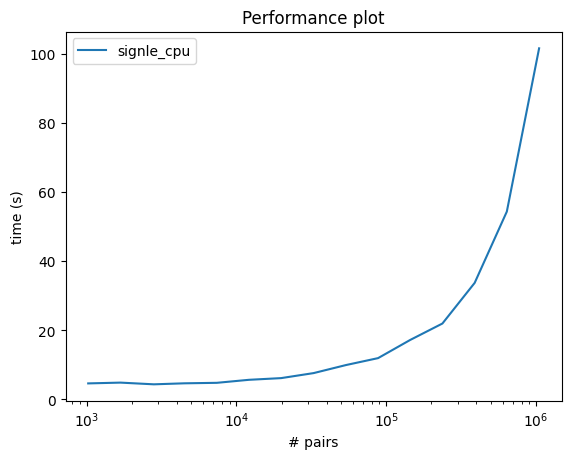

In [4]:
plt.semilogx(pairs, times, label='signle_cpu')
plt.title(f"Performance plot")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

In [5]:
import json, os

benchmark_summary = dict(
        pairs=pairs,
        times=times,
        device=torch.cuda.get_device_name(),
        nproc=os.cpu_count(),    
    )
print(json.dumps(benchmark_summary,indent=1))

{
 "pairs": [
  1024,
  1681,
  2809,
  4489,
  7396,
  12100,
  19881,
  32761,
  53824,
  88209,
  144400,
  237169,
  389376,
  638401,
  1048576
 ],
 "times": [
  4.61960701299904,
  4.848240357001487,
  4.353743239000323,
  4.6457689220005705,
  4.787713708999945,
  5.658327465000184,
  6.151166523999564,
  7.604971161999856,
  9.928251830999216,
  11.936628774001292,
  17.188605341001676,
  21.95269652499701,
  33.71507874500094,
  54.35259559399856,
  101.6103339609981
 ],
 "device": "NVIDIA GeForce RTX 2070 with Max-Q Design",
 "nproc": 12
}
